In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
orientation = ["LEADING", "LAGGING"]

In [15]:
class Gene:
    def __init__(self, position, orientation, basal_expression):
        self.position = position
        self.orientation = orientation
        self.basal_expression = basal_expression

In [3]:
# Make an initial list of genes
nb_genes = 10
genome_size = 10_000
gene_length = 100
intergene = 900
interaction_dist = 2500

In [16]:
def generate_genes(nb_genes, gene_length, intergene):
    genes = []

    for gene in range(nb_genes):
        #new_gene = {'pos': gene * (gene_length + intergene),
        #            'orient': np.random.randint(2),
        #            'basal_expr': np.random.random()}
        new_gene = Gene(position=gene * (gene_length + intergene),
                        orientation=np.random.randint(2),
                        basal_expression=np.random.random()) 
        genes.append(new_gene)

    return genes

In [19]:
def interaction(genes, i_1, i_2):
    # calcul de l'influence de la transcription du gène 2 sur le gène 1    
    
    if i_1 == i_2: # It's the same gene
        return 1.0
    
    
    gene_1 = genes[i_1]
    gene_2 = genes[i_2]
    
    pos_1 = gene_1.position
    pos_2 = gene_2.position
    
    ## On veut savoir si le gène 1 est avant le gène 2 ou après
    # Avant : -------1--2-------- ou -2---------------1-
    # Après : -------2--1-------- ou -1---------------2-
    
    if pos_1 < pos_2: # -------1--2-------- ou -1---------------2-
        if pos_2 - pos_1 < genome_size + pos_1 - pos_2: # -------1--2--------
            distance = pos_2 - pos_1
            is_before = True
        else: # -1---------------2-
            distance = genome_size + pos_1 - pos_2
            is_before = False
            
    else: # -------2--1-------- ou -2---------------1-
        if pos_1 - pos_2 < genome_size + pos_2 - pos_1: # -------2--1--------
            distance = pos_1 - pos_2
            is_before = False
        else:
            distance = genome_size + pos_2 - pos_1
            is_before = True
    
    ## Orientations relatives
    if (is_before and gene_2.orientation == 0) or (not is_before and gene_2.orientation == 1):
        sign = +1
    else:
        sign = -1
                            
    strength = max(1 - distance/interaction_dist, 0)
                
    return sign * strength

In [20]:
def make_inter_matrix(genes):
    inter_matrix = np.zeros((nb_genes, nb_genes))
    
    for i in range(nb_genes):
        for j in range(nb_genes):
            inter_matrix[i, j] = interaction(genes, i, j)
    
    return inter_matrix

In [21]:
def run_system(inter_matrix, init_expr, nb_steps):
    nb_genes = len(init_expr)
    temporal_expr = np.zeros((nb_genes, nb_steps))
    
    # Initial values at t = 0
    temporal_expr[:, 0] = expression_levels[:]
    
    # Iterate the system
    for t in range(1, nb_steps):
        temporal_expr[:, t] = inter_matrix @ temporal_expr[:, t-1]
        temporal_expr[:, t] = np.maximum(temporal_expr[:, t], 0)
        temporal_expr[:, t] = np.minimum(temporal_expr[:, t], 2)
        
    return temporal_expr

In [32]:
def plot_expr(genes, temporal_expr, plot_name):
    nb_genes, nb_steps = temporal_expr.shape
    
    #colormap = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))
    
    plt.figure(figsize=(9, 6), dpi=200)
    
    for gene in range(nb_genes):
        linestyle = 'solid' if genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[gene, :],
                 linestyle=linestyle,
                 #color=colormap[gene],
                 label=f'Gene {gene}')
    
    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')
    
    plt.legend(loc='center right')
        
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')

In [23]:
genes = generate_genes(nb_genes, gene_length, intergene)

inter_matrix = make_inter_matrix(genes)

expression_levels = np.array([gene.basal_expression for gene in genes])

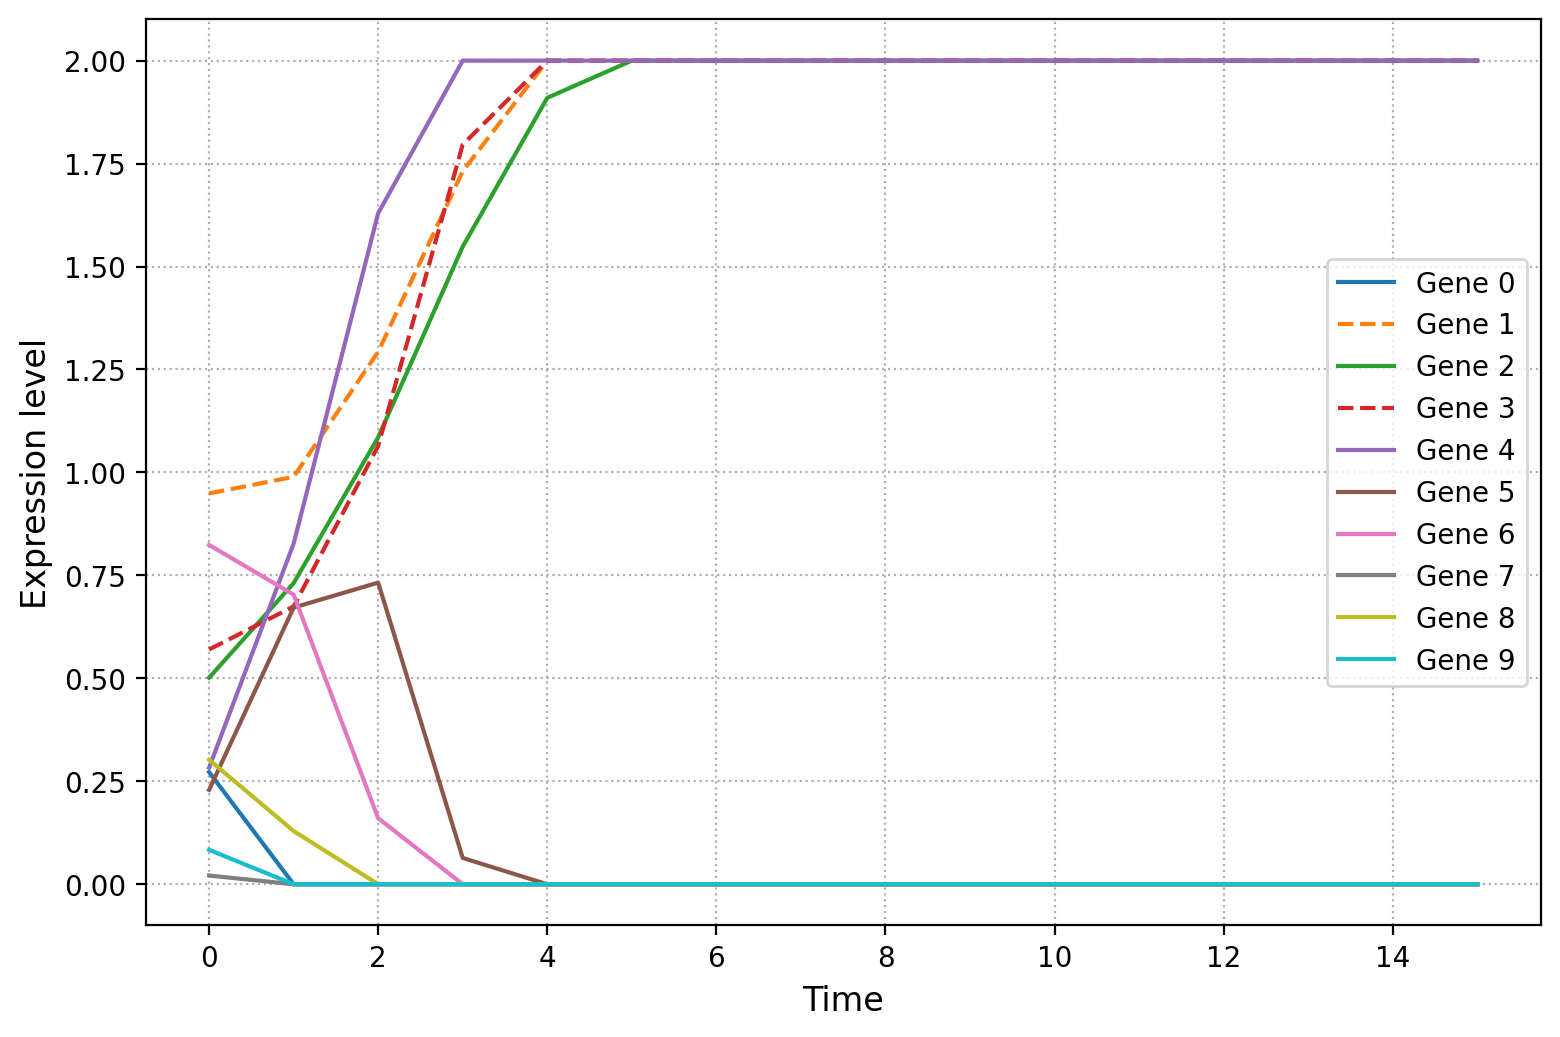

In [33]:
plot_expr(genes, run_system(inter_matrix, expression_levels, 16), 'baseline')

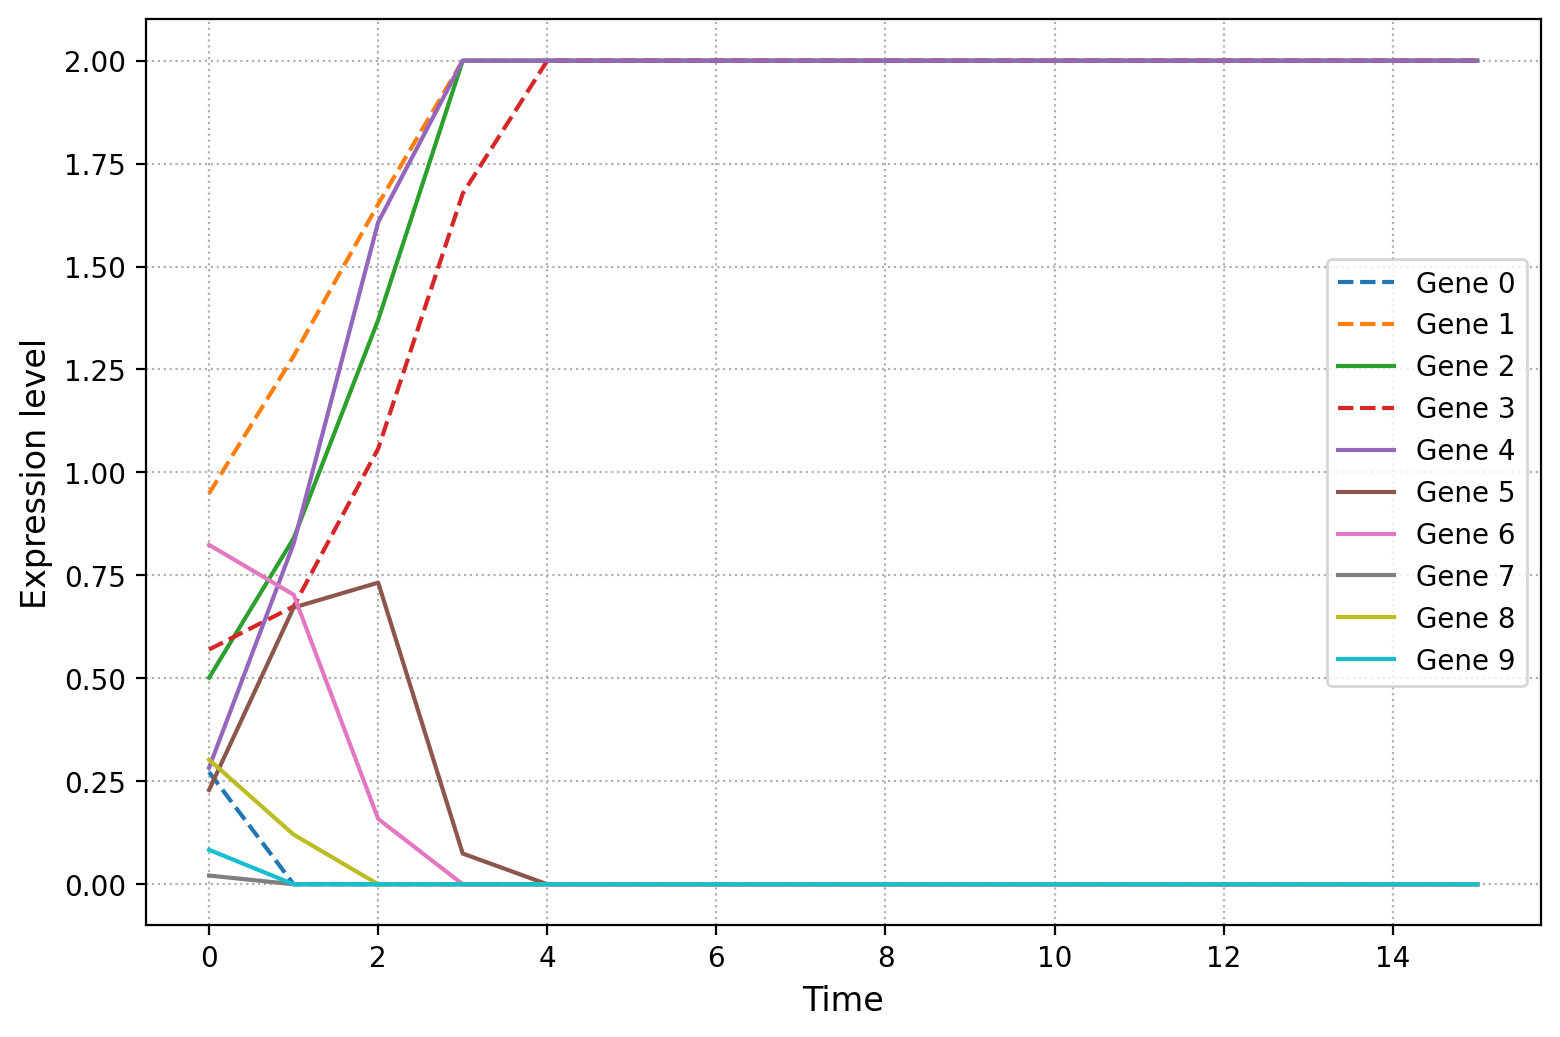

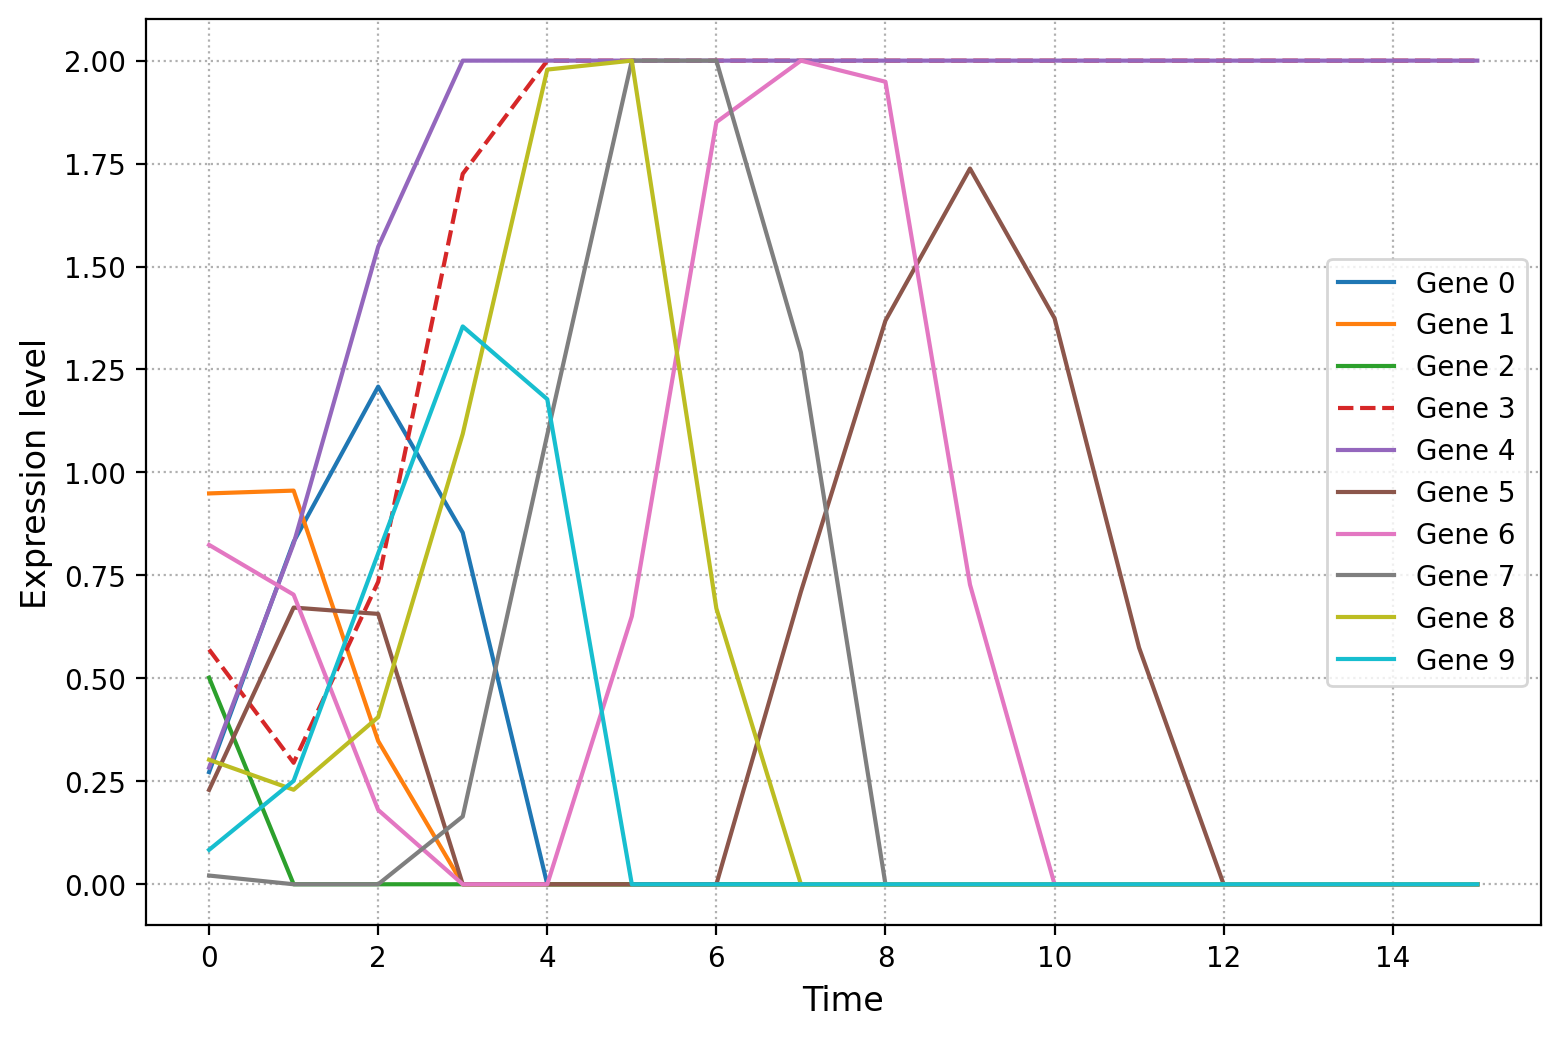

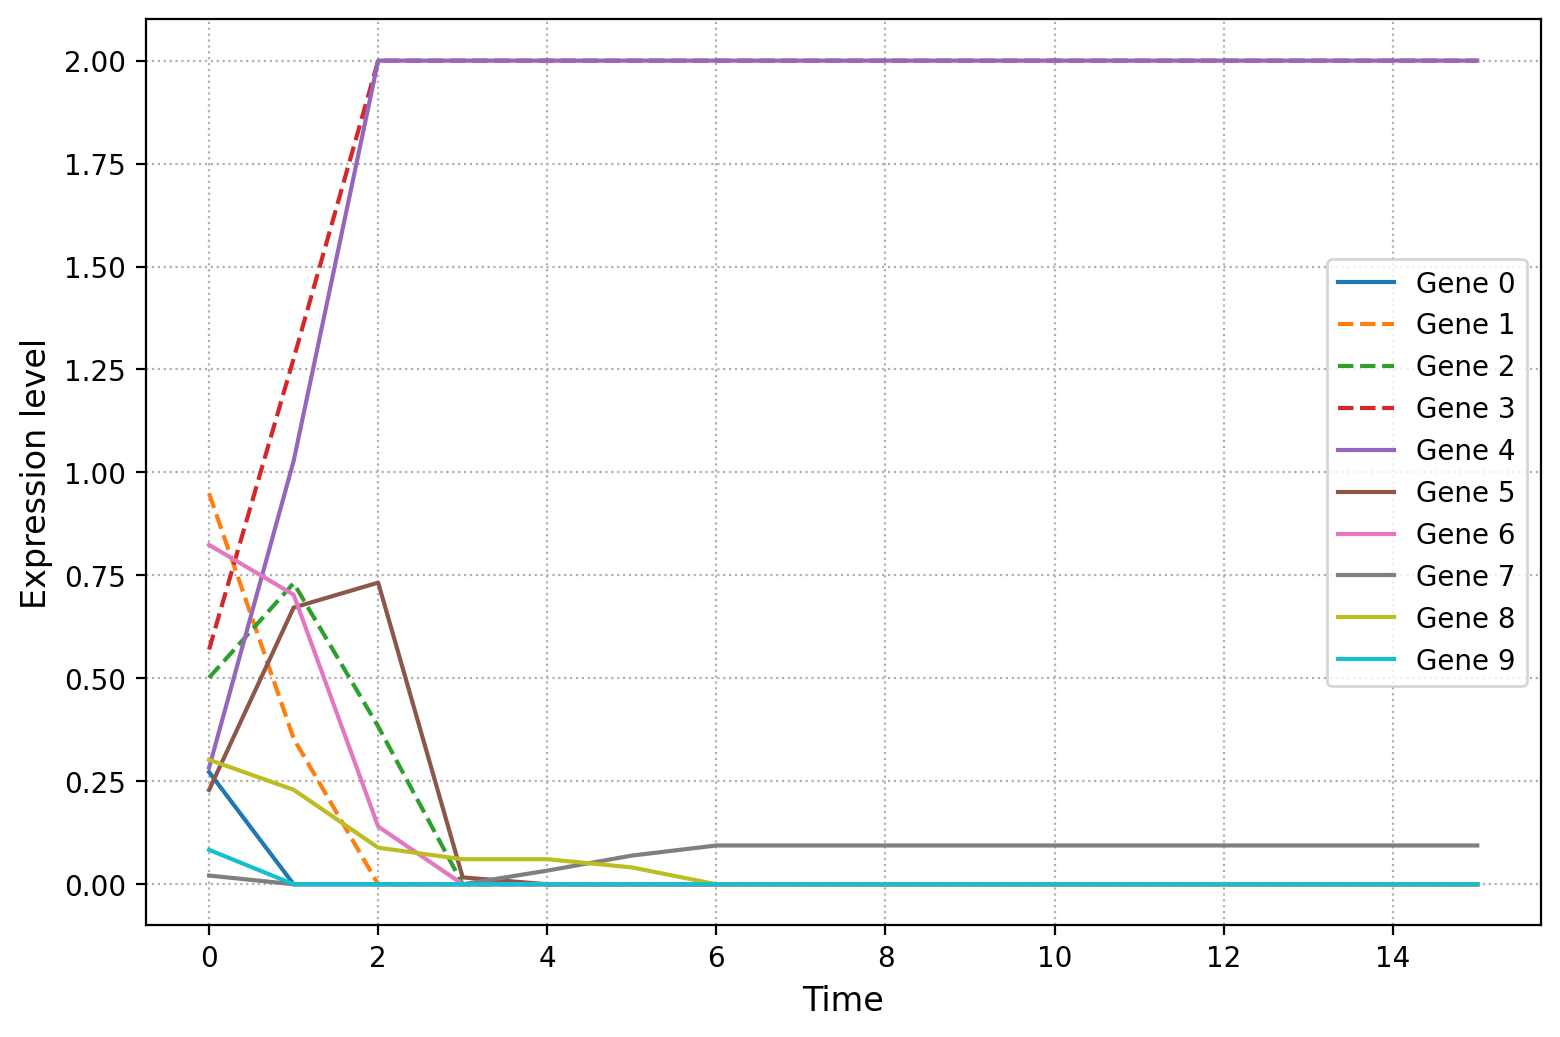

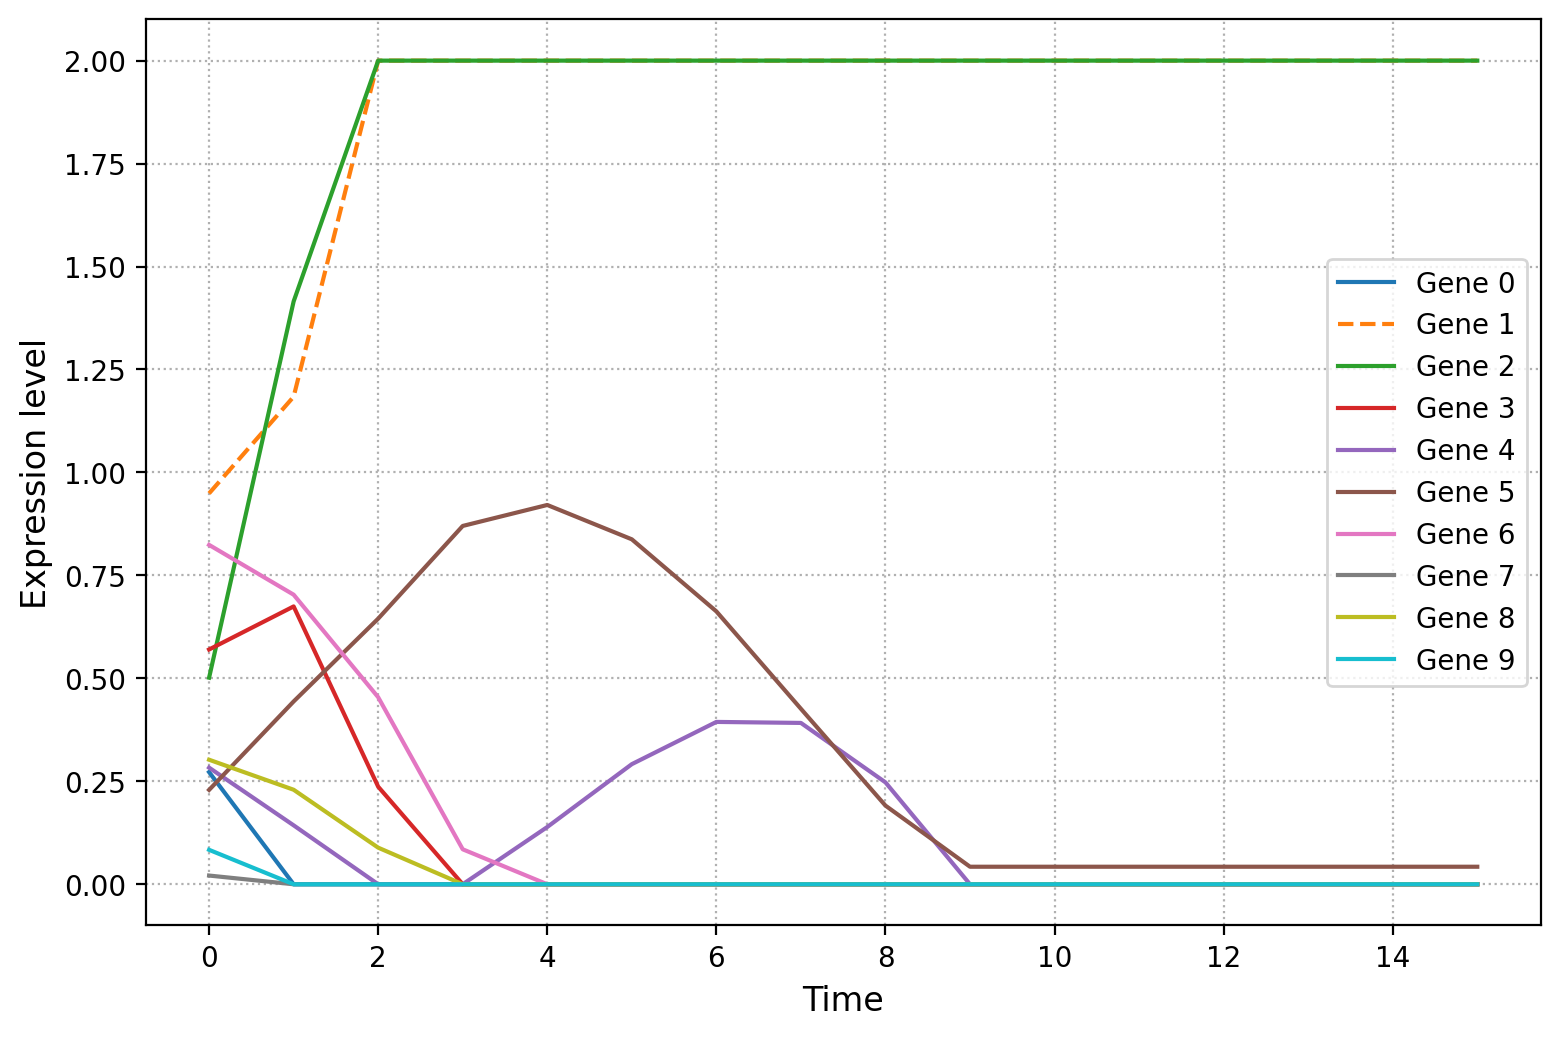

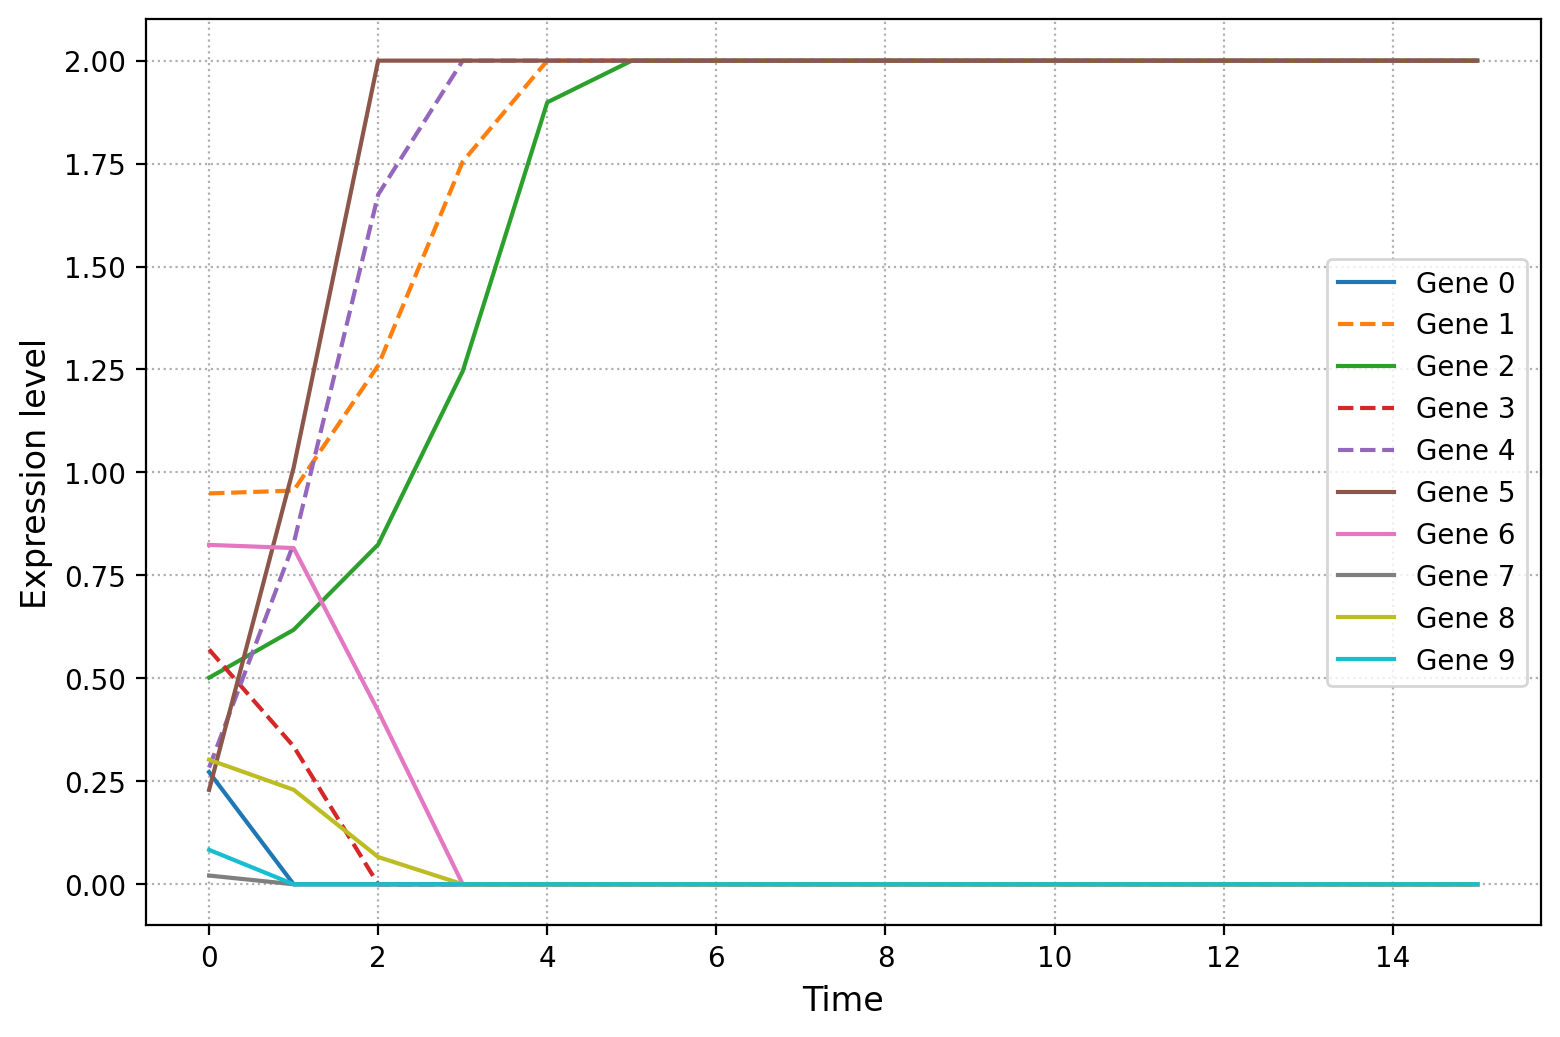

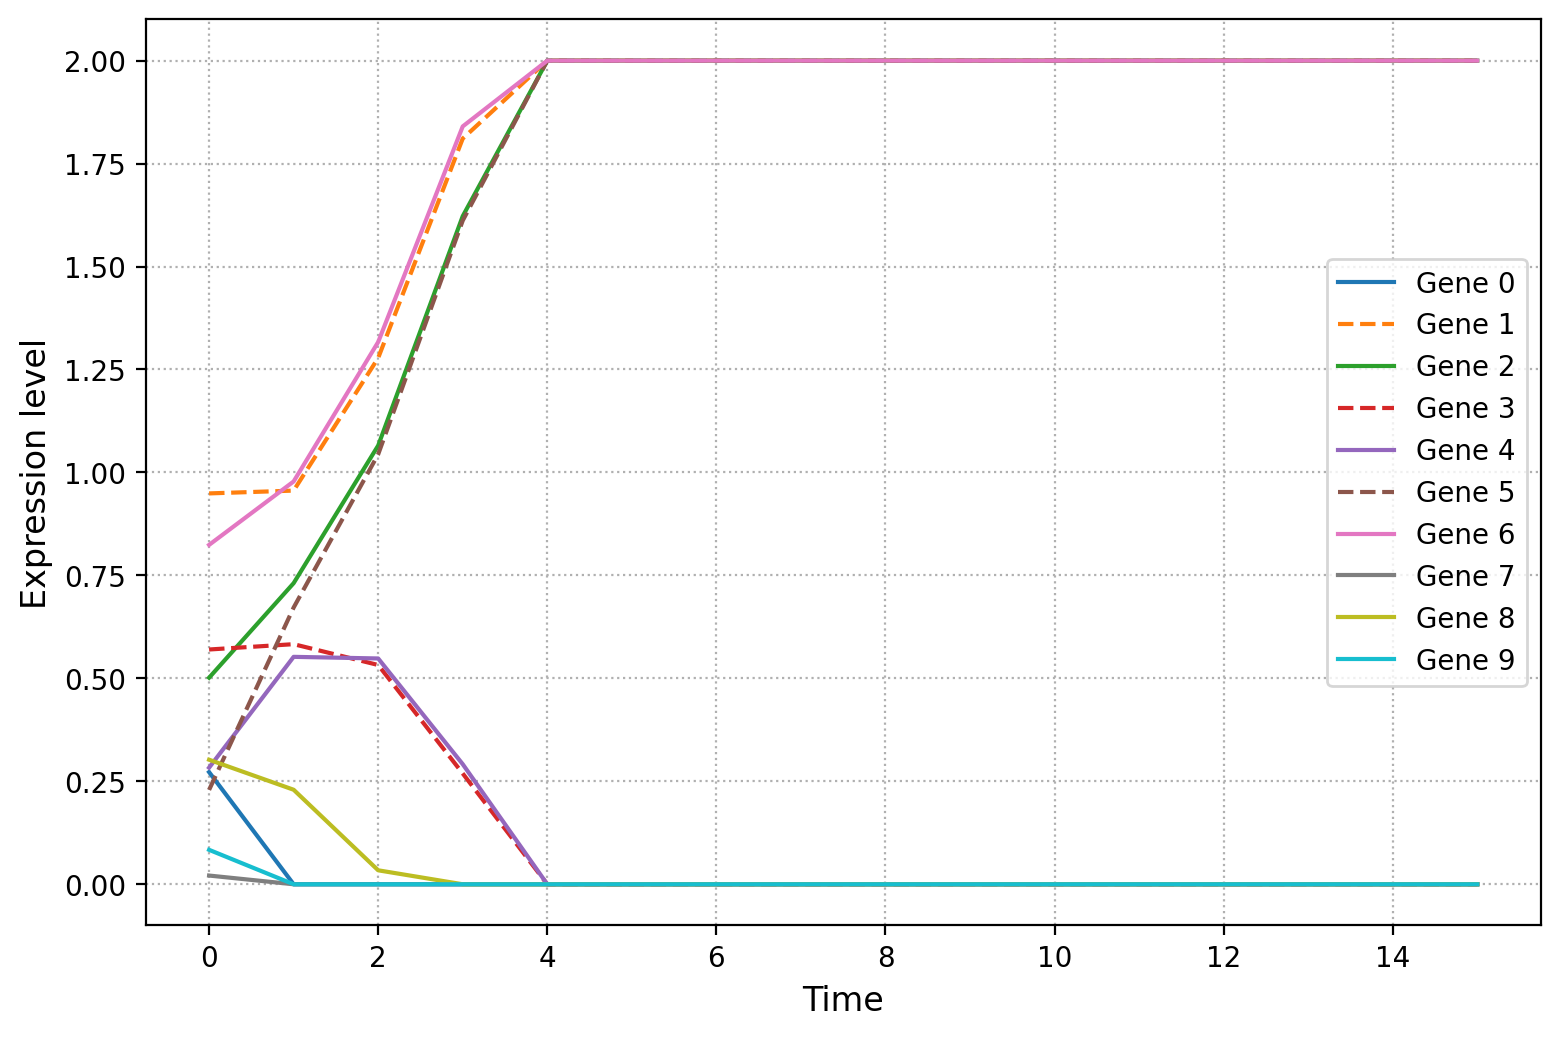

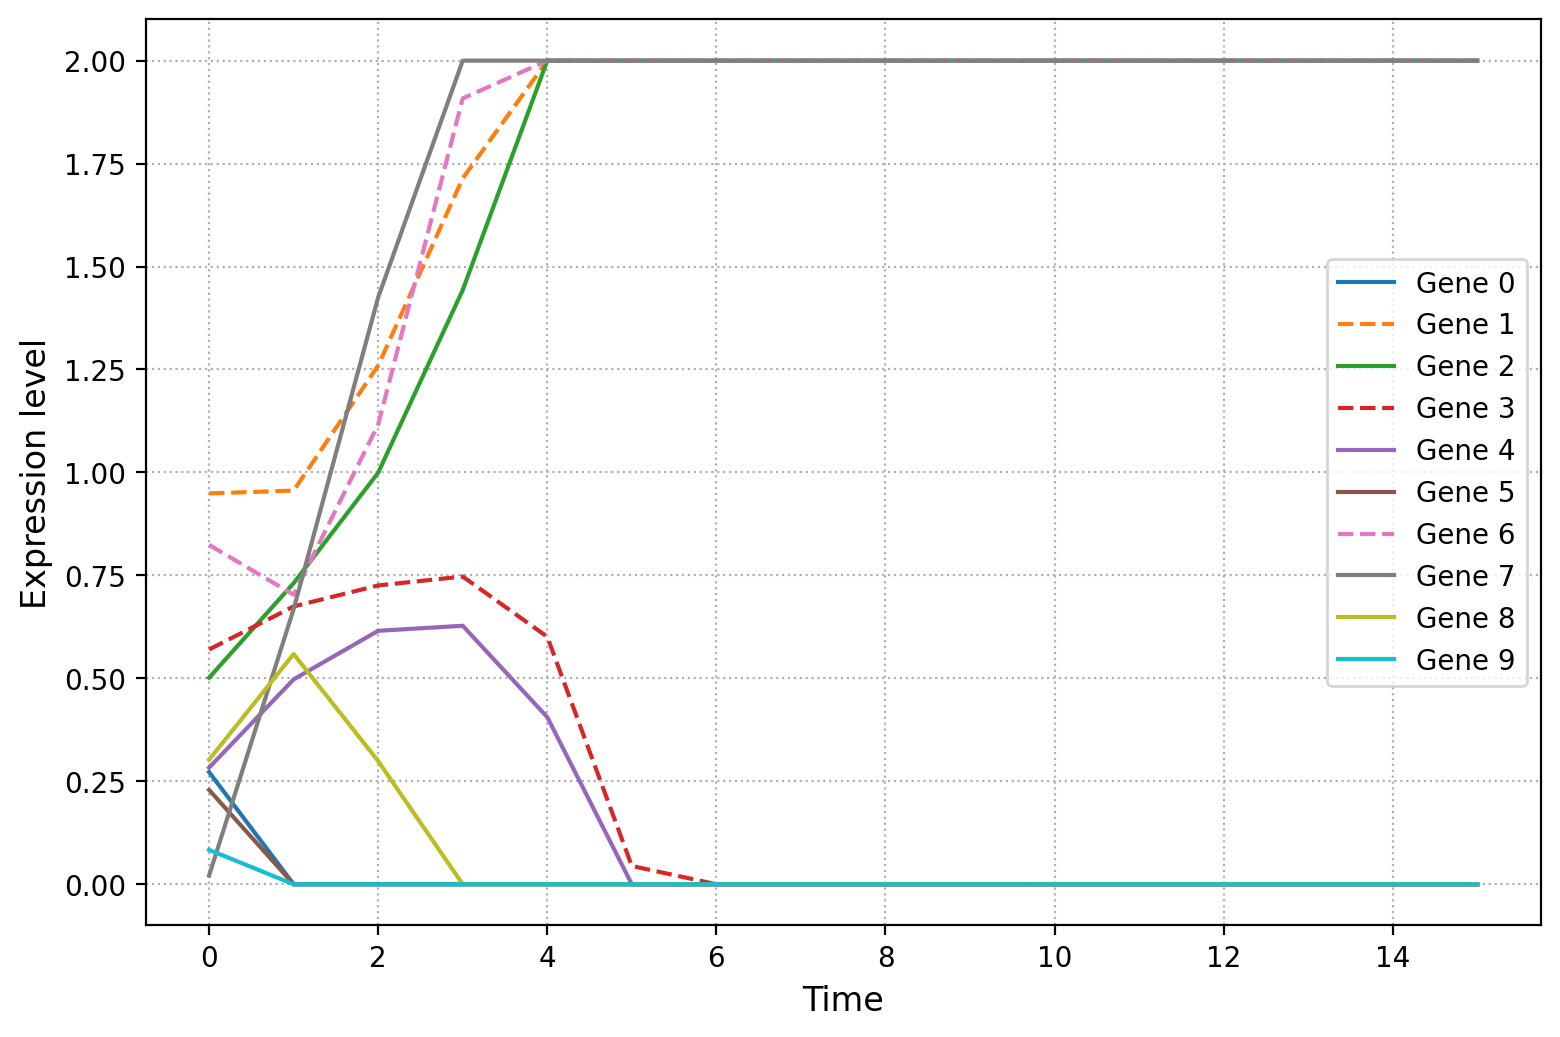

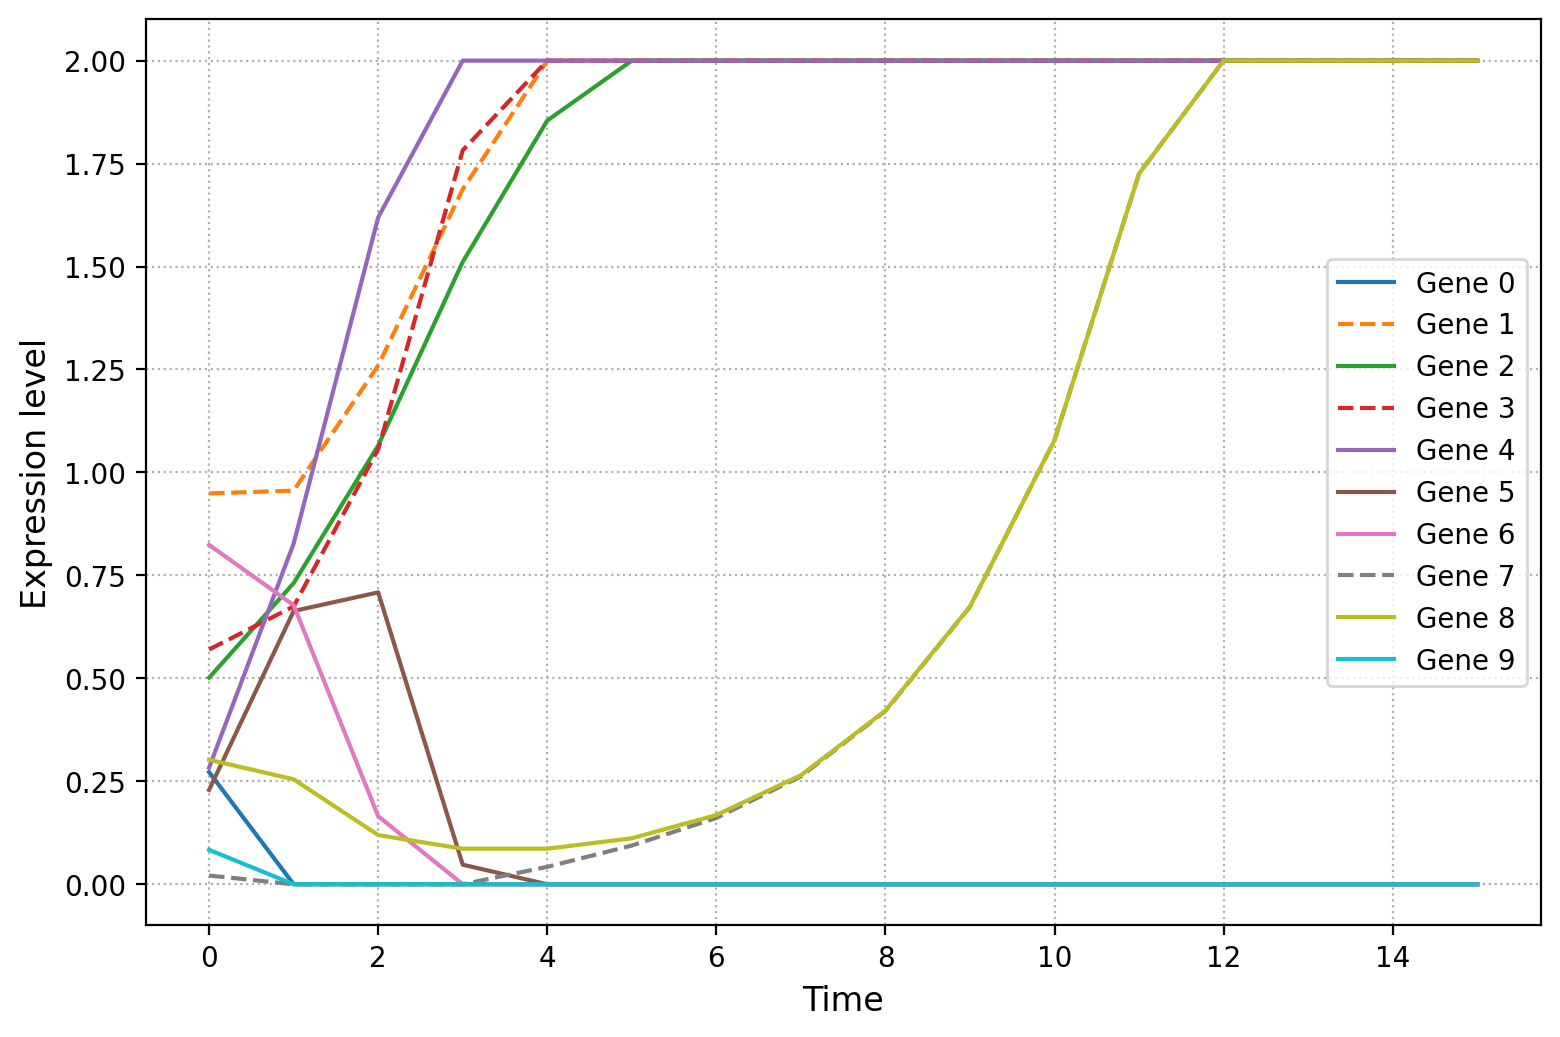

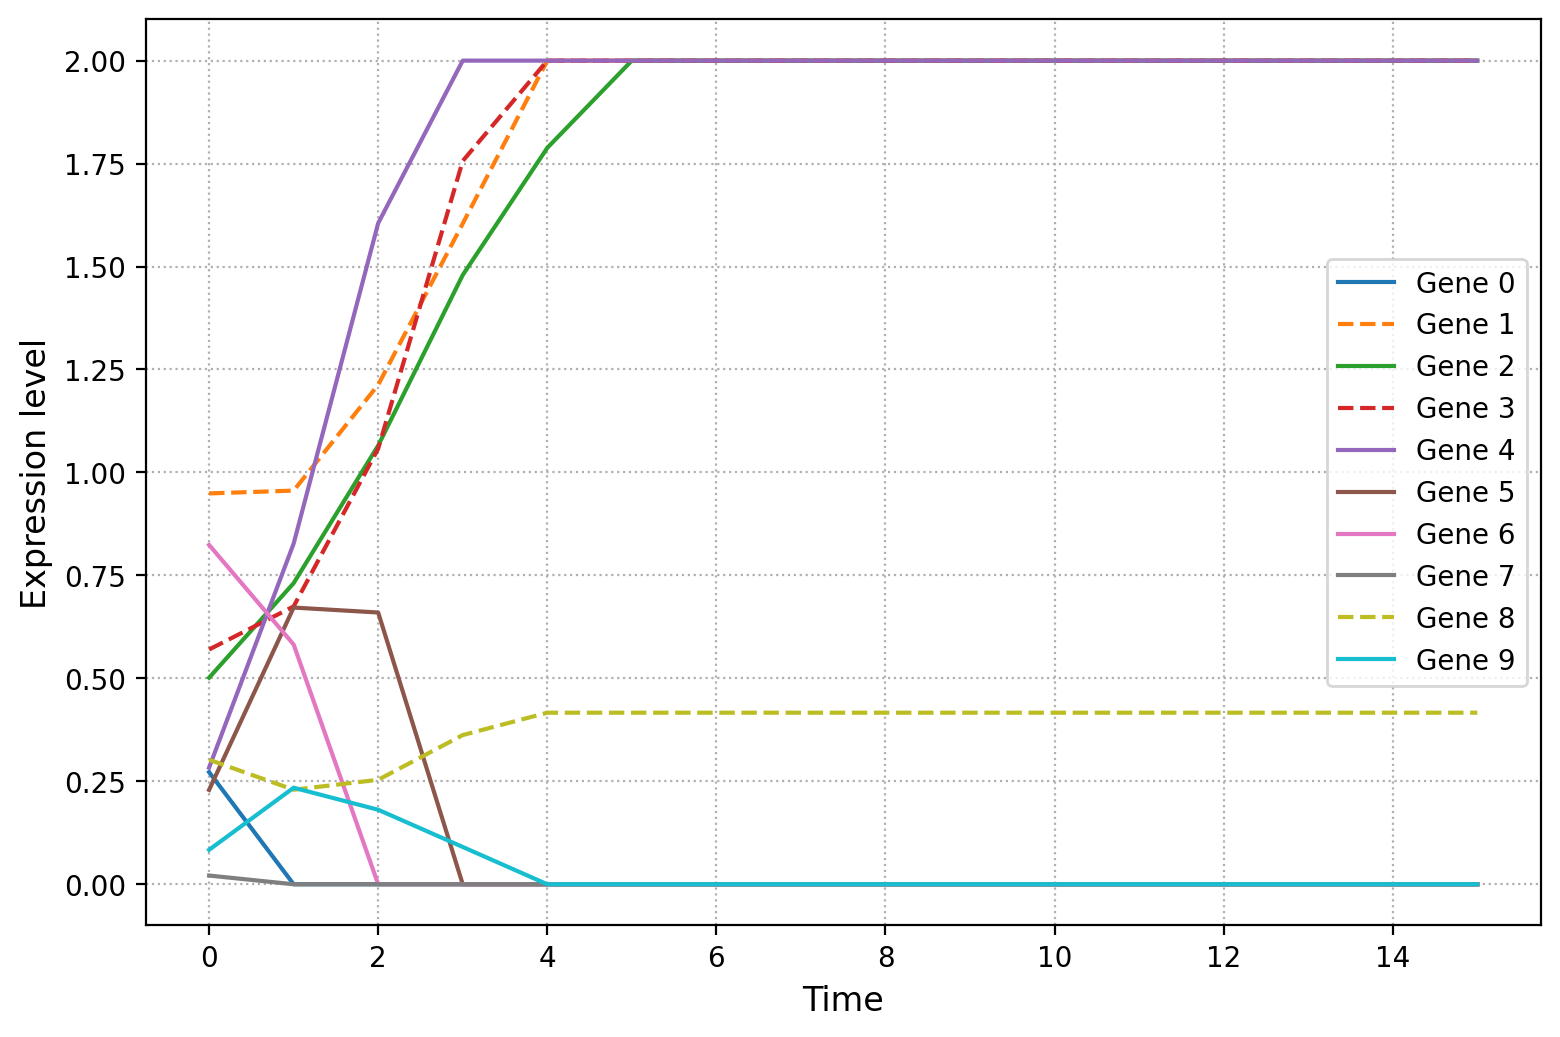

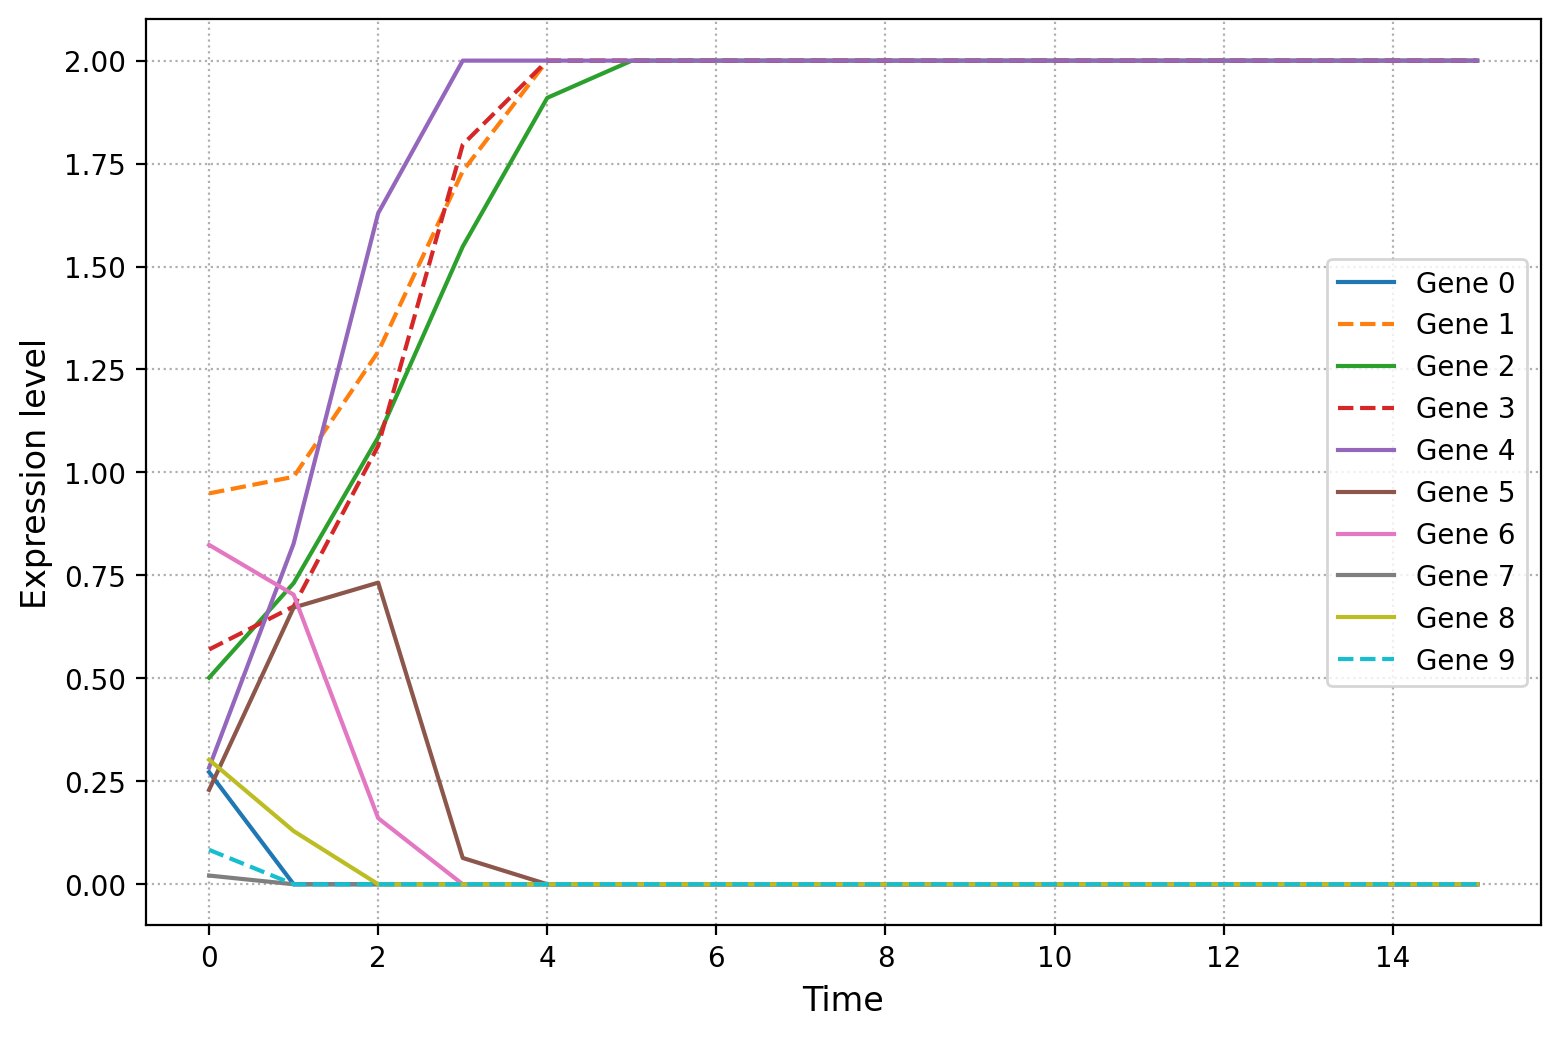

In [34]:
for i_switched_gene in range(len(genes)):
    
    # Switch the current gene 
    to_switch = genes[i_switched_gene]
    to_switch.orientation = 1 - to_switch.orientation
    inter_matrix = make_inter_matrix(genes)
    plot_expr(genes, run_system(inter_matrix, expression_levels, 16), f'switched_{i_switched_gene}')
    # Reset the gene to its former orientation
    to_switch.orientation = 1 - to_switch.orientation